# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

# Задачи

1. Выявить зависимость между фактом погашения кредита в срок и семейным положением клиента;
2. Выявить зависимость между количеством детей клиента и возвратом кредита в срок;
3. Выявить зависимость между уровнем дохода и возвратом кредита в срок;
4. Выявить зависимость между целью кредита и возвратом кредита в срок.

# Импорт библиотек

In [1]:
import pandas as pd
from pymystem3 import Mystem
m = Mystem()
from collections import Counter
import matplotlib.pyplot as plt

# Первичный осмотр

**Описание данных:**
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

С помощью метода `info()` посмотрим насколько типы данных соответсвуют описанию:

In [2]:
df_main = pd.read_csv('data.csv')
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Можно заметить, что в целом типы данных соответсвуют ожидаемым. Однако, ожидалось, что столбец **days_employed** будет иметь тип `int64`.

Кроме того видно, что количество отсутствующих значений в столбцах **days_employed** и **total_income** совпадают. Что указывает на их взамосвязь.

Посмотрим на первые 10 зачений таблицы.

In [3]:
df_main.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Сразу можно заметить проблемы с регистром в столбце **education**, но это меньшая из проблем. Значения в столбце **days_employed** мало того что вещественные, так еще и большей частью отрицательные.

Методом `describe()` посмотрим на общую информацию о числовых значениях датафрейма.

In [4]:
df_main.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


Можно заметить подозрительное значение -1 в столбце children, и то что б***о***льшая часть значений в **days_employed** принимает отрицательное значение (но при этом среднее значение положительное и равно 63046.497661, что очень подозрительно).

Еще видно, что минимальный возраст клиента в таблице = 0. А максимальный срок работы в днях 401755.400475 дней, что намного больше ожидаемой продолжительности жизни человека.

Разберемся со всем этим на следующем этапе.

# Предобработка данных

## Обработка пропусков
Во всей таблице пропуски имеются только в столбцах **days_employed** и **total_income**. Причем количество этих пропусков совпадает.

Проверим насколько тесна эта взамосвязь.

In [5]:
print(df_main[df_main['days_employed'].isna()]['total_income'].unique())

[nan]


Из чего следует, что все отсутсвующие значения этих столбцов соответсвуют друг другу. 

Можно предположить, что все эти отсутсвующие значения соответствуют безработным, так как если нет стажа, значит нет и работы, значит нет и зарлаты, тогда все отсутсвующие значения во всех столбцах можно заполнить нулями. 

Проверим для кого характерны эти пустые значения.

In [6]:
print(df_main[df_main['days_employed'].isna()]['income_type'].value_counts())

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64


Сотрудники/госслужащие/предприниматели не могут быть безработными, значит предположение не оправдалось. Значит заполнить пустые значения нулями это не выход.

Случайность распределения отсутсвующих значений указывает на то, что скорее всего они пропали в результате технической ошибки.

В таком случае лучшим решением будет заполнить отсутсвующие значения медианными значениями для каждой группы.

In [7]:
for column in ['days_employed', 'total_income']:
    for in_type in ['пенсионер', 'госслужащий', 'компаньон', 'сотрудник', 'предприниматель']:
        median_col_type = df_main.groupby('income_type')[column].median()[in_type]
        print(f'Медиана в столбце {column} для типа занятости {in_type} = {median_col_type}')
        df_main.loc[df_main['income_type'] == in_type, column] = df_main.loc[df_main['income_type'] == in_type, column].fillna(median_col_type)
    print()
# Двойной цикл перебирает значения для имен столбцов и для тех типов занятости в которых есть пустые значения.
# Находит медиану для данного типа занятости в данном столбце и выводит их на экран. А после присваивает значение
# соответствующей медианы соответсвующей пустой позиции в датафрейме.

Медиана в столбце days_employed для типа занятости пенсионер = 365213.3062657312
Медиана в столбце days_employed для типа занятости госслужащий = -2689.3683533043886
Медиана в столбце days_employed для типа занятости компаньон = -1547.3822226779334
Медиана в столбце days_employed для типа занятости сотрудник = -1574.2028211070854
Медиана в столбце days_employed для типа занятости предприниматель = -520.8480834953765

Медиана в столбце total_income для типа занятости пенсионер = 118514.48641164352
Медиана в столбце total_income для типа занятости госслужащий = 150447.9352830068
Медиана в столбце total_income для типа занятости компаньон = 172357.95096577113
Медиана в столбце total_income для типа занятости сотрудник = 142594.39684740017
Медиана в столбце total_income для типа занятости предприниматель = 499163.1449470857



Для проверки выведем первые 20 значений.

In [8]:
df_main.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


И увидим, что 12ая строчка, в которой раньше были пустые значения, теперь на месте пустых значений имеет соответсвующие медианы.

Можно проверить более основательно.

Проверим какие значения принимают столбцы **days_employed** и **total_income** для типа занятости сотрудник.

In [9]:
for col in df_main[df_main['income_type'] == 'сотрудник'][['days_employed', 'total_income']].columns:
    
    print(df_main[df_main['income_type'] == 'сотрудник'][col].value_counts())

-1574.202821    1105
-8437.673028       1
-315.711018        1
-2190.296191       1
-1520.463972       1
                ... 
-619.377708        1
-6079.595061       1
-1025.253569       1
-3353.561535       1
-1984.507589       1
Name: days_employed, Length: 10015, dtype: int64
142594.396847    1105
253875.639453       1
48744.975831        1
143819.385505       1
189064.245183       1
                 ... 
93552.645144        1
69812.185025        1
112794.464159       1
182421.880829       1
82047.418899        1
Name: total_income, Length: 10015, dtype: int64


И увидим что там появилось 1105 медианных значений как и должно быть.

На всякий случай проверим датафрейм на наличие пустых значений.

In [10]:
print(df_main.isnull().sum())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


Пустых значений больше не осталось, переходим к следующему этапу.

## Замена типа данных

Тип данных имеет смысл менять только в столбцах **days_employed** и **total_income** c `float` на `int`, исключительно для того чтобы убрать незначительную для конечных расчетов дробную часть из их вещественных значений. Можно было бы превести значения в **total_income** в копейки, но это не столь значительно, и поэтому этим можно пренебречь.

Для замены используется метод **astype**, так как именно он преобразует значения во всем столбце в желаемый тип данных.

In [11]:
df_main['days_employed'] = df_main['days_employed'].astype('int')
df_main['total_income'] = df_main['total_income'].astype('int')
df_main.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,-5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,-926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,-2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,-152,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,-6929,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,-2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


Видно, что замена типа прошла успешно.

## Обработка дубликатов

Для начала приведем значения **education** к единому регистру. Так различия в регистре один из распространенных источников появления неявных дубликатов.

In [12]:
df_main['education'] = df_main['education'].str.lower()

Сразу же проверим успешность смены регистра.

In [13]:
df_main['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Теперь уберем все полные дубликаты из датафрейма.

In [14]:
print(df_main.duplicated().sum()) 

71


Для подсчета количества дубликатов последовательно используются методы duplicated(), который находит все продублированные значения в таблице. А затем sum(), который складывает все значения в Series которую вернул метод duplicated(), благо значения True можно складывать как единицы.

Для избавления от дубликатов используется метод drop_duplicates(), так как именно он это и делает. Избавляется от дубликатов. После пременяется метод reset_index(), чтобы переприсвоить рядам индексы, так как они были смещены из-за применения предыдущего метода.

In [15]:
df_main = df_main.drop_duplicates().reset_index(drop=True)
print(df_main.duplicated().sum()) 

0


Все дубликаты убраны.

Поскольку существование в такой маленькой выборке двух людей с таким большим количеством абсолютно одинаковых параметров крайне маловероятно, скорее всего причиной существования дубликатов стала техническая ошибка.

## Лемматизация

Определим самые популярные слова в причинах взятия кредита. И сделаем из них обобщающие слова.

Для начала извлечем все причины взятия кредита из таблицы и объеденим их в один список, а далее в строку.

In [16]:
purposes_unique = df_main['purpose'].unique()
purposes_str = ' '.join(purposes_unique)
print(purposes_unique)

['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'ремонт жилью' 'заняться высшим образованием']


Посмотрим на количество уникальных причин.

In [17]:
len(purposes_unique)

38

Найдем наиболее популярные леммы.

In [18]:
lemmas = m.lemmatize(purposes_str)
print(Counter(lemmas))

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, '\n': 1})


Из чего видно, что причины взятия кредита можно обобщить до: 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'свадьба': 3. Если сложить все количество появлений обобщающих слов во всех причинах, то можно получить 10 + 9 + 9 + 7 + 3 = 38. Что соответсвует общему количеству уникальных причин.

Кроме того в дальнейшем разумно было бы сменить обобщающее слово для причин объединяющих 'недвижимость' и 'жилой' с 'недвижимость' на 'жилье'.

Создадим список обобщающих слов.

In [19]:
lemma_words = ['недвижимость', 'автомобиль', 'образование', 'жилье', 'свадьба']

Напишем функцию с помощью которой позже обобщим отзывы до одного характерного слова.

In [20]:
def text_to_lemma (text, lemmas_list):
    '''
    Проверяет наличие леммы из текста, в списке лемм и возвращает соответсвующую лемму из списка.
    Если леммы из текста нет в списке возвращает строку 'разное'.
    '''
    try:
        i = 0
        for lemma in lemmas_list:
            i +=1
            lematized_text = m.lemmatize(text)
            if lemma in lematized_text:
                return lemma
            elif i < len(lemmas_list): continue
            else: return 'разное'
    except Exception as err: 
        print('Неожиданное значение, проверьте введенные аргументы:', text ,' |||| ', lemmas_list)
        print (f'Ошибка :{repr(err)}')
        return None

Применим эту функцию к списку уникальных значений столбца **purpose**. И внесем все эти значения в словарь dict_text_to_lemma, чтобы потом использовать его в функции replace(). Такой способ работает быстрее чем прямая лемматизация всего столбца, с последующим извечением основной леммы в другой столбец.

In [21]:
dict_text_to_lemma ={}
for i in purposes_unique:
    dict_text_to_lemma[i] = text_to_lemma(i, lemma_words)

Посмотрим на получившийся словарь.

In [22]:
dict_text_to_lemma

{'покупка жилья': 'жилье',
 'приобретение автомобиля': 'автомобиль',
 'дополнительное образование': 'образование',
 'сыграть свадьбу': 'свадьба',
 'операции с жильем': 'жилье',
 'образование': 'образование',
 'на проведение свадьбы': 'свадьба',
 'покупка жилья для семьи': 'жилье',
 'покупка недвижимости': 'недвижимость',
 'покупка коммерческой недвижимости': 'недвижимость',
 'покупка жилой недвижимости': 'недвижимость',
 'строительство собственной недвижимости': 'недвижимость',
 'недвижимость': 'недвижимость',
 'строительство недвижимости': 'недвижимость',
 'на покупку подержанного автомобиля': 'автомобиль',
 'на покупку своего автомобиля': 'автомобиль',
 'операции с коммерческой недвижимостью': 'недвижимость',
 'строительство жилой недвижимости': 'недвижимость',
 'жилье': 'жилье',
 'операции со своей недвижимостью': 'недвижимость',
 'автомобили': 'автомобиль',
 'заняться образованием': 'образование',
 'сделка с подержанным автомобилем': 'автомобиль',
 'получение образования': 'образов

И заменим значения для ключей 'покупка жилой недвижимости' и 'строительство жилой недвижимости' на 'жилье'.

In [23]:
dict_text_to_lemma['покупка жилой недвижимости'] = 'жилье'
dict_text_to_lemma['строительство жилой недвижимости'] = 'жилье'

Наконец можно создать **purpose_lemma** с соответсвующим обобщающим словом.

In [24]:
df_main['purpose_lemma'] = df_main['purpose'].replace(dict_text_to_lemma)

Проверка:

In [25]:
print(df_main['purpose_lemma'].unique())
df_main.head(10)

['жилье' 'автомобиль' 'образование' 'свадьба' 'недвижимость']


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemma
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба
5,0,-926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье
6,0,-2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,жилье
7,0,-152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,образование
8,2,-6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,свадьба
9,0,-2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,жилье


## Артефакты
К артефактам отнесем все значения выбивающиеся из большинства, или значения не имеющие смысла.

Начнем с самых очевидных.
### Пол
Проверим какие значения встречаются в столбце **gender**.

In [26]:
df_main['gender'].value_counts()

F      14174
M       7279
XNA        1
Name: gender, dtype: int64

In [27]:
df_main[df_main['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemma
10684,0,-2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости,недвижимость


Среди всех клиентов имеется один бездетный гендерквир. Толерантность говорит нам, что его необходимо оставить в списке. Однако он всего один и его удаление не повредит общей картине. Так что:

In [28]:
df_main = df_main[df_main['gender'] != 'XNA']

### Возраст
Проверим наличие слишком молодых/старых клиентов.

In [29]:
df_main[df_main['dob_years'] >= 100]['dob_years'].value_counts()

Series([], Name: dob_years, dtype: int64)

In [30]:
df_main[df_main['dob_years'] <= 18]['dob_years'].value_counts()

0    101
Name: dob_years, dtype: int64

Слишком старых в списке нет, а вот слишком молодых 101 человек.

Проверим к каким категориям они относятся.

In [31]:
df_main[df_main['dob_years'] <= 18]['income_type'].value_counts()

сотрудник      55
пенсионер      20
компаньон      20
госслужащий     6
Name: income_type, dtype: int64

Особенно сильно в данном списке смущают 20 новорожденных пенсионеров.

Чтобы это исправить на место нулей присвоим медианное значение характерное для каждого типа клиента.

In [32]:
for in_type in ['пенсионер', 'госслужащий', 'компаньон', 'сотрудник']:
    median_col_type = int(df_main.groupby('income_type')['dob_years'].median()[in_type])
    print(f'Медиана в столбце \'dob_years\' для типа занятости {in_type} = {median_col_type}')
    df_main.loc[df_main['income_type'] == in_type, 'dob_years'] = df_main.loc[df_main['income_type'] == in_type, 'dob_years'].replace(0, median_col_type)
# Цикл перебирает значения для имен столбцов и для тех типов занятости в которых есть нули.
# Находит медианы для данного типа занятости в столбце 'dob_years' переводит их в int и выводит их на экран.
# А после заменяет нули в датафрейме на значение соответствующей медианы.

Медиана в столбце 'dob_years' для типа занятости пенсионер = 60
Медиана в столбце 'dob_years' для типа занятости госслужащий = 40
Медиана в столбце 'dob_years' для типа занятости компаньон = 39
Медиана в столбце 'dob_years' для типа занятости сотрудник = 39


Проверим сроботало ли.

In [33]:
df_main[df_main['dob_years'] <= 18]['income_type'].value_counts()

Series([], Name: income_type, dtype: int64)

Сработало.

### Количество детей
Посмотрим какие там встречаются значения.

In [34]:
df_main['children'].value_counts()

 0     14090
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Обнаруживается 76 значений  по 20 и 47 значений по -1. Посмотрим для кого они характерны.

---
20 детей

In [35]:
df_main[df_main['children'] == 20]['income_type'].value_counts()

сотрудник      43
компаньон      22
пенсионер       9
госслужащий     2
Name: income_type, dtype: int64

In [36]:
df_main[df_main['children'] == 20]['family_status'].value_counts()

женат / замужем          49
гражданский брак         12
Не женат / не замужем     9
вдовец / вдова            4
в разводе                 2
Name: family_status, dtype: int64

---
-1 детей

In [37]:
df_main[df_main['children'] == -1]['income_type'].value_counts()

сотрудник      26
компаньон       9
пенсионер       8
госслужащий     4
Name: income_type, dtype: int64

In [38]:
df_main[df_main['children'] == -1]['family_status'].value_counts()

женат / замужем          29
гражданский брак          5
Не женат / не замужем     5
в разводе                 4
вдовец / вдова            4
Name: family_status, dtype: int64

---
Как видно ни для кого конкретного. Поскольку количество детей теснее связано с семейным статусом чем с типом клиента, придется заменить странные значения медианным значением для человека данного семейного положения.

В ходе работы уже приходилось пару раз выполнять схожую задачу, так что лучше на будущее написать функцию.

In [39]:
def median_for_value (df=None, column_to_process=None, columns_list=None, values_list=None, operation_type='fillna', val_to_replace=None, final_type='float'):
    '''
    Функция берет датафрейм df и находит в нём медианное значение в столбцах указанных в списке columns_list характерных для указаных в списке values_list значений столбца column_to_process.
    Выводит эти медианы на экран, а после заменяет значения (либо пустые либо указанные в аргументе val_to_replace) в датафрейме на соответсвующую медиану.
    Аргумент operation_type может принять занчение 'fillna' или 'replace', по умолчанию или в случае если указанное значение является неожиданным выполняет заполнение пустых значений датафрейма.
    Если аргумент operation_type принимает значение 'replace', то необходимо заполнить аргумент operation_type, который указывает какое значение в датафрейме будет заменено.
    Тип выходных данных определяется аргументом final_type, который  может принять значения 'int' или 'float', по умолчанию или в случае если указанное значение является неожиданным выходные данные получают тип float.
    '''
    for column in columns_list:
        for value in values_list:
            if final_type == 'int':
                val_median = int(df.groupby(column_to_process)[column].median()[value])
            else: val_median = df.groupby(column_to_process)[column].median()[value]
            print(f'Медиана в столбце {column} для значения {value} = {val_median}')
            if operation_type == 'replace':
                df.loc[df[column_to_process] == value, column] = df.loc[df[column_to_process] == value, column].replace(val_to_replace, val_median)
            else: df.loc[df[column_to_process] == value, column] = df.loc[df[column_to_process] == value, column].fillna(val_median)
        print()

Объяснение получилось больно мудреным, ну да ладно. Проверим её работу.

In [40]:
median_for_value(df_main, 'family_status', ['children'], ['женат / замужем', 'гражданский брак', 'Не женат / не замужем', 'вдовец / вдова', 'в разводе'], 'replace', 20, 'int')

Медиана в столбце children для значения женат / замужем = 0
Медиана в столбце children для значения гражданский брак = 0
Медиана в столбце children для значения Не женат / не замужем = 0
Медиана в столбце children для значения вдовец / вдова = 0
Медиана в столбце children для значения в разводе = 0



In [41]:
median_for_value(df_main, 'family_status', ['children'], ['женат / замужем', 'гражданский брак', 'Не женат / не замужем', 'вдовец / вдова', 'в разводе'], 'replace', -1, 'int')

Медиана в столбце children для значения женат / замужем = 0
Медиана в столбце children для значения гражданский брак = 0
Медиана в столбце children для значения Не женат / не замужем = 0
Медиана в столбце children для значения вдовец / вдова = 0
Медиана в столбце children для значения в разводе = 0



In [42]:
df_main['children'].value_counts()

0    14213
1     4808
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

Да, действительно видно, что все артефактные значения стали медианными. В данном случае медиана количества детей для всех данных семейных статусов равна 0.

### Трудовой стаж
Как было видно еще при первичном осмотре трудовой стаж принимает либо отрицательные либо положительные значения. Причем в среднем положительное значение, на 2 порядка больше чем модуль отрицательного.

In [43]:
df_main[df_main['days_employed'] > 0]['days_employed'].mean()/abs(df_main[df_main['days_employed'] < 0]['days_employed'].mean())

159.7476824531834

Кроме того если принять во внимание, что стаж указан в днях, то даже минимальное положительное значение в разы дольше человеческой жизни.

In [44]:
min(df_main[df_main['days_employed'] > 0]['days_employed'])

328728

А 328728 дней это около 900 лет.

Однако, посмотрим для кого характерны эти значения.

In [45]:
df_main[df_main['days_employed'] > 0]['income_type'].unique()

array(['пенсионер', 'безработный'], dtype=object)

In [46]:
df_main[df_main['days_employed'] < 0]['income_type'].unique()

array(['сотрудник', 'компаньон', 'госслужащий', 'предприниматель',
       'студент', 'в декрете'], dtype=object)

Значит положительные значения характерны только для пенсионеров и безработных. Но что они означают остается неясным.

Отрицательные же значения наоборот хорошо вписываются в описание столбца **days_employed**, и действительно являются количеством дней стажа. А знак минус скорее всего к ним был прикреплен, чтобы различие между значениями для работающих и неработающих людей было нагляднее. Так как для неработающих людей в столбце **days_employed** заложен либо другой смысл, либо другая единица измерения.

Что конкретно заложено в **days_employed** для пенсионеров и безработных неизвестно, и ,к счастью, выяснять это необязательно. Так как среди задач нет ни одной связанной с трудовым стажем клиентов.

## Категоризация данных

Значения столбца с отзывами были категоризированы в пункте **Лемматизация**. Поскольку в дальнейшем будет необходимо установить зависимость между уровнем дохода и возращением кредита в срок, разобъем клиентов на категории по уровню дохода.

Разобъем их на квартили по доходу:
1. Низкий
2. Средний
3. Выше среднего
4. Высокий

В результате клинты разделились на категории согласно цели взятия кредита, и их ежемесячному доходу.

In [47]:
df_main['total_income_category'] = pd.qcut(df_main['total_income'], 4, labels=["низкий", "средний", "выше среднего", "высокий"])
print(df_main['total_income_category'].value_counts())

средний          5479
низкий           5364
высокий          5363
выше среднего    5247
Name: total_income_category, dtype: int64


Поскольку одна из задач требует лишь факт наличия детей, а не их количество, то можно добавить столбец подтверждающий является ли клиент родителем

In [48]:
df_main ['is_parent'] = df_main['children'] != 0
df_main.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemma,total_income_category,is_parent
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье,высокий,True
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,средний,True
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье,выше среднего,False
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,высокий,True
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,выше среднего,False


# Решение задач

## 1. Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для ответа на этот вопрос сравним между собой соотношения: кол-во клиентов с долгом/общее количество клиентов, с разбивкой по наличию детей.

In [49]:
df_grouped_parent = df_main.groupby('is_parent').agg({'debt':['sum', 'count']})
df_grouped_parent['sum/count'] = df_grouped_parent['debt']['sum']/df_grouped_parent['debt']['count']
df_grouped_parent

debt        sum/count
            sum  count          
is_parent                       
False      1072  14213  0.075424
True        669   7240  0.092403

Из чего видно, что среди бездетных клиентов доля тех, кто является должником, ниже чем среди клиентов с детьми.

**Вывод**

Согласно данным таблицы бездетные клиенты возвращают кредиты в срок приблизительно на 2 % чаще чем клиенты с детьми.

## 2. Есть ли зависимость между семейным положением и возвратом кредита в срок?

Для ответа на этот вопрос сравним между собой соотношения: кол-во клиентов с долгом/общее количество клиентов, с разбивкой по семейному положению.

In [50]:
df_grouped_family = df_main.groupby('family_status').agg({'debt':['sum', 'count']})
df_grouped_family['sum/count'] = df_grouped_family['debt']['sum']/df_grouped_family['debt']['count']
df_grouped_family.sort_values(by='sum/count')

debt        sum/count
                       sum  count          
family_status                              
вдовец / вдова          63    959  0.065693
в разводе               85   1195  0.071130
женат / замужем        931  12339  0.075452
гражданский брак       388   4150  0.093494
Не женат / не замужем  274   2810  0.097509

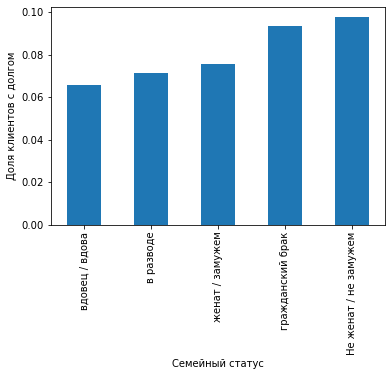

In [51]:
df_grouped_family.sort_values(by='sum/count').plot.bar(y='sum/count', legend='')
plt.ylabel('Доля клиентов с долгом')
plt.xlabel('Семейный статус')
plt.show()

**Вывод**

Чаще всего среди других групп клиентов в срок кредит возвращают вдовцы и вдовы. Реже всего - неженатые/ незамужние. Если же сравнивать две самые большие группы в выборке, то можно заметить, что женатые/ замужние возвращают кредит в срок на 2% чаще чем сторонники гражданского брака.

## 3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для ответа на этот вопрос сравним между собой соотношения: кол-во клиентов с долгом/общее количество клиентов, с разбивкой по уровню дохода.

In [52]:
df_grouped_wealth = df_main.groupby('total_income_category').agg({'debt':['sum', 'count']})
df_grouped_wealth['sum/count'] = df_grouped_wealth['debt']['sum']/df_grouped_wealth['debt']['count']
df_grouped_wealth.sort_values(by='sum/count')

debt       sum/count
                       sum count          
total_income_category                     
высокий                383  5363  0.071415
низкий                 427  5364  0.079605
выше среднего          448  5247  0.085382
средний                483  5479  0.088155

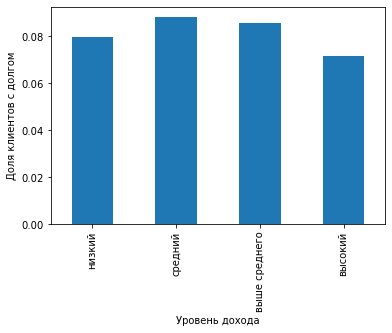

In [53]:
df_grouped_wealth.plot.bar(y='sum/count', legend='')
plt.ylabel('Доля клиентов с долгом')
plt.xlabel('Уровень дохода')
plt.show()

**Вывод**

Наиболее надежными являются клиенты с высоким уровнем дохода. И что удививительно несильно от них отстают клиенты с низким уровнем дохода. Наименее же надежными являются клиенты со средним уровнем дохода.

## 4. Как разные цели кредита влияют на его возврат в срок?

Для ответа на этот вопрос сравним между собой соотношения: кол-во клиентов с долгом/общее количество клиентов, с разбивкой по цели взятия кредита.

In [54]:
df_grouped_purpose = df_main.groupby('purpose_lemma').agg({'debt':['sum', 'count']})
df_grouped_purpose['sum/count'] = df_grouped_purpose['debt']['sum']/df_grouped_purpose['debt']['count']
df_grouped_purpose.sort_values(by='sum/count')

debt       sum/count
               sum count          
purpose_lemma                     
жилье          397  5690  0.069772
недвижимость   385  5120  0.075195
свадьба        186  2324  0.080034
образование    370  4013  0.092200
автомобиль     403  4306  0.093590

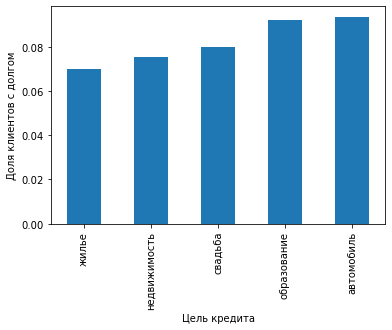

In [55]:
df_grouped_purpose.sort_values(by='sum/count').plot.bar(y='sum/count', legend='')
plt.ylabel('Доля клиентов с долгом')
plt.xlabel('Цель кредита')
plt.show()

**Вывод**

Чаще всего в срок возращают кредиты взятые на недвижимость, будь то жилая или нежилая недвижимость. Реже всего возвращают в срок кредиты взятые на атомобиль или образование. Кредит на свадьбу занимает промежуточное положение.

# Общий вывод

Согласно обработанным данным наибольшей потенциальной способностью вернуть кредит банку обладают люди относящиеся к категориям:
- Бездетные
- Вдовцы/вдовы/разведенные/находящиеся в официальном браке
- Люди с низким или высоким доходом
- Люди берущие кредит на недвижимость

Наименьшей же потенциальной способностью вернуть кредит вовремя обладают:
- Родители
- Неженатые/незамужние/находящиеся в гражданском браке
- Люди среднего дохода
- Люди берущие кредит на автомобиль/образование

Шутки ради посмотрим разницу между клиентами с максимальной и минимальной способностью вернуть кредит вовремя (согласно вышеуказанным выводам)

In [56]:
df_check = df_main[(df_main['family_status'] == 'вдовец / вдова') | (df_main['family_status'] == 'в разводе') | (df_main['family_status'] == 'женат / замужем')]
df_check = df_check[df_check['is_parent'] == False]
df_check = df_check[(df_check['purpose'] == 'жилье') | (df_check['purpose'] == 'недвижимость')]
df_check = df_check[(df_check['total_income_category'] == 'низкий') | (df_check['total_income_category'] == 'высокий')]
print('Количество клиентов, оцененных как благонадежные:', df_check['debt'].count())
print('Доля несвоевременно выплативших кредит среди благонадежных:', df_check['debt'].sum()/df_check['debt'].count())

Количество клиентов, оцененных как благонадежные: 309
Доля несвоевременно выплативших кредит среди благонадежных: 0.045307443365695796


In [57]:
df_check_bad = df_main[(df_main['family_status'] == 'Не женат / не замужем') | (df_main['family_status'] == 'гражданский брак')]
df_check_bad = df_check_bad[df_check_bad['is_parent'] == True]
df_check_bad = df_check_bad[(df_check_bad['purpose'] == 'образование') | (df_check_bad['purpose'] == 'автомобиль')]
df_check_bad = df_check_bad[(df_check_bad['total_income_category'] == 'средний')]
print('Количество клиентов, оцененных как неблагонадежные:', df_check_bad['debt'].count())
print('Доля несвоевременно выплативших кредит среди неблагонадежных:',df_check_bad['debt'].sum()/df_check_bad['debt'].count())

Количество клиентов, оцененных как неблагонадежные: 20
Доля несвоевременно выплативших кредит среди неблагонадежных: 0.1


Действительно разница заметна, но из-за больших различий в размере выборок однозначных выводов сделвть нельзя.